<p align="center">
    <img style="width:60%" src="https://image.freepik.com/free-vector/new-message-concept-landing-page_52683-26980.jpg">
</p>

[Image source](https://www.freepik.com/free-vector/new-message-concept-landing-page_5757124.htm/)

<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">SMS spam.</h1>

## Please use nbviewer to read this notebook to use all it's features:
https://nbviewer.org/github/sersonSerson/Projects/blob/master/NaturalLanguage/SMS%20spam/SMS%20spam.ipynb


# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>

## 1. [EDA.](#step1)
## 2. [Establish baseline.](#step2)
## 3. [Preprocess data.](#step3)
## 4. [Choose model.](#step4)
## 5. [Analyze model mistakes.](#step5)
## 6. [Conclusion.](#step6)

# SMS Spam Collection Dataset
https://www.kaggle.com/uciml/sms-spam-collection-dataset

## Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected
 for SMS Spam research. It contains one set of SMS messages in English of 5,574
 messages, tagged according to being ham (legitimate) or spam.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import seaborn as sns
import wordcloud

import spacy
from sklearn.preprocessing import MinMaxScaler
from spacy.matcher import Matcher
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict, \
    cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from itertools import product
from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.options.display.max_rows = 75
pd.options.display.max_colwidth = 300
pd.options.mode.chained_assignment = None

In [3]:
N_JOBS = 7

In [4]:
# Configure Matplotlib and seaborn
plt.style.use('seaborn-muted')
sns.set_palette('muted')
plt.rcParams['figure.figsize'] = (16,5);
plt.rcParams['figure.facecolor'] = '#daf2e1'
plt.rcParams['axes.facecolor'] = '#daf2e1'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['image.cmap']=cm.tab10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
cmap = cm.tab10
blue = cmap.colors[0]
orange = cmap.colors[1]
green = cmap.colors[2]

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [blue, orange,
                                                             green])
matplotlib.cm.register_cmap("mycolormap", cmap)
cpal = sns.color_palette("mycolormap", n_colors=60)


<div id="step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. EDA. </span>

## Load data

In [5]:
df_initial = pd.read_csv('Data/spam.csv', encoding='iso-8859-1')
df_initial.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


In [6]:
df_initial.shape

(5572, 5)

In [7]:
df_initial.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

## Merge different parts of message

In [8]:
df_initial['FullMessage'] = df_initial['v2'] + \
    np.where(df_initial['Unnamed: 2'].isna(), '', df_initial['Unnamed: 2']) + \
    np.where(df_initial['Unnamed: 3'].isna(), '', df_initial['Unnamed: 3']) + \
    np.where(df_initial['Unnamed: 4'].isna(), '', df_initial['Unnamed: 4'])
df_initial = df_initial.rename(columns={'v1': 'Label'})
df = df_initial[['FullMessage', 'Label']]
df

,FullMessage,Label
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives around here though",ham
...,...,...
5567,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate.",spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other suggestions?",ham
5570,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free,ham


## Word cloud on raw messages

In [9]:
full_str = ' '.join(list(df['FullMessage'].str.lower()))

# Compare Spam and  ham (non-spam) word cloud

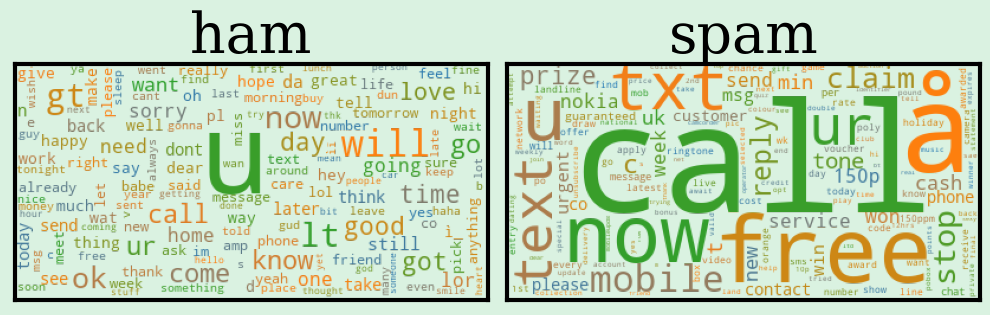

In [10]:
def categorical_word_clouds(df, dependent_variable):
    unique_classes = df[dependent_variable].unique()
    n_classes = int(len(unique_classes))
    n_columns = 2
    n_rows = int(np.ceil(n_classes / n_columns))

    wc = dict()

    fig, axes = plt.subplots(n_rows, n_columns, figsize=(10, 10))
    for dv_class, ax in zip(unique_classes, axes):
        wc_class = wordcloud.WordCloud(
            background_color=None, mode="RGBA",
            relative_scaling=1,
            colormap=cmap, collocations=False,
            random_state=0, max_words=150)
        wc[dv_class] = wc_class
        df_class = df[df['Label'] == dv_class]
        class_str =  ' '.join(list(df_class['FullMessage'].str.lower()))
        class_img = wc_class.generate(class_str)
        ax.imshow(class_img, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['bottom'].set_linewidth(3)
        ax.spines['top'].set_linewidth(3)
        ax.spines['right'].set_linewidth(3)
        ax.spines['left'].set_linewidth(3)
        ax.set_title(dv_class, fontsize=40)

    plt.tight_layout()
    plt.show()
    return wc

wc = categorical_word_clouds(df, 'Label')

## Check dependent variable distiribution
* 87% ham
* 13% spam


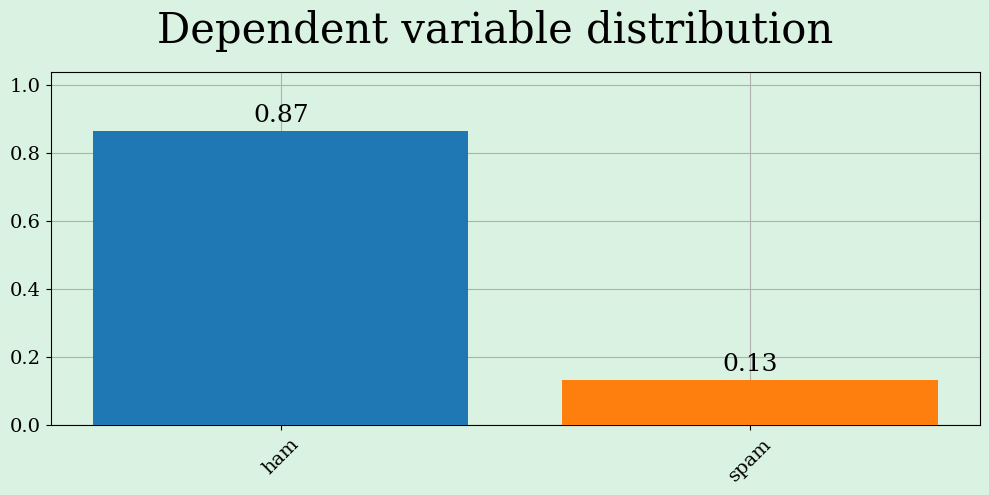

In [11]:
def autolabel(rects, ax, decimals=2, inside=False, old_rects=None):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for index, rect in enumerate(rects):
        height = rect.get_height()
        value = round(height, decimals)
        if inside:
            height = height / 2
        if old_rects:
            height += old_rects[index].get_height()
        ax.annotate('{}'.format(value),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    size=18,# 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def classes_distribution(df, dependent_variable, title='', text_labels=None):
    dv_count = df[dependent_variable].value_counts(normalize=True)
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle('Dependent variable distribution' + title)
    rects = ax.bar(dv_count.index, dv_count.values,
                   color=[blue, orange], zorder=3)
    ax.set_ylim(0, dv_count.max() * 1.2)
    if text_labels is None:
        text_labels = dv_count.index.unique()
    ax.set_xticks(text_labels)
    ax.set_xticklabels(text_labels, rotation=45)
    autolabel(rects, ax, decimals=2)
    plt.tight_layout()
    plt.show()

classes_distribution(df, 'Label')

## Check the length of the messages

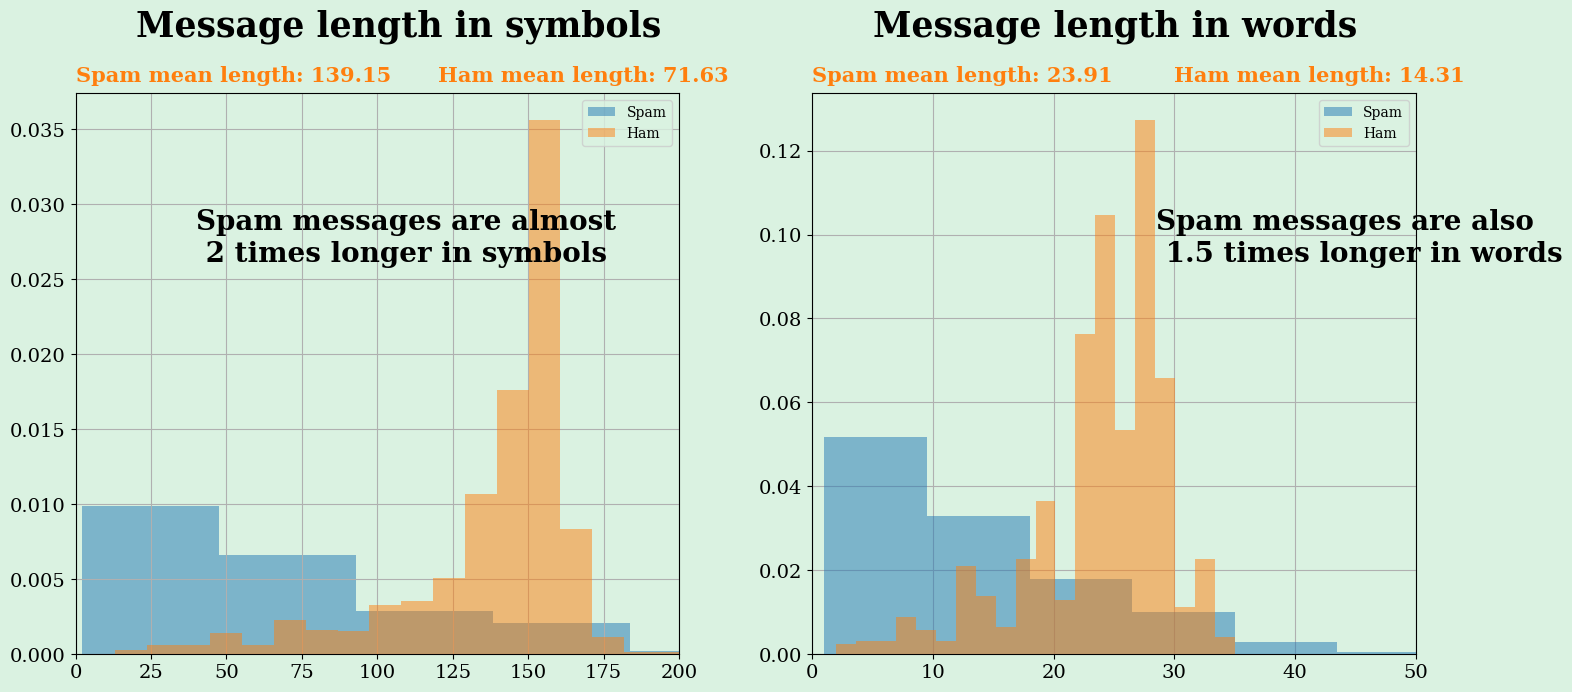

In [12]:
dependent_variable = 'Label'
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
df_ham = df[df['Label'] == 'ham']
df_spam = df[df['Label'] == 'spam']
axes[0].hist(df_ham['FullMessage'].str.len(),
        density=True, alpha=0.5, color=blue, bins=20, label='Spam')
axes[0].hist(df_spam['FullMessage'].str.len(),
        density=True, alpha=0.5, color=orange, zorder=3, bins=20, label='Ham')
axes[0].legend()
axes[0].set_xlim(0, 200)
axes[0].text(0.2, 0.7, 'Spam messages are almost \n 2 times longer in symbols',
       transform = axes[0].transAxes, size=20, fontweight='bold')
axes[0].text(0.10, 1.10, 'Message length in symbols',
       transform = axes[0].transAxes, size=25, fontweight='bold')
axes[0].text(0.6, 1.02, f'Ham mean length: '
                        f'{df_ham["FullMessage"].apply(len).mean().round(2)}',
             transform = axes[0].transAxes, size=15, fontweight='bold',
             color=orange)
axes[0].text(0.0, 1.02, f'Spam mean length: '
                        f'{df_spam["FullMessage"].apply(len).mean().round(2)}',
             transform = axes[0].transAxes, size=15, fontweight='bold',
             color=orange)

axes[1].hist(df_ham['FullMessage'].str.split().apply(len),
        density=True, alpha=0.5, color=blue, zorder=3, bins=20, label='Spam')
axes[1].hist(df_spam['FullMessage'].str.split().apply(len),
        density=True, alpha=0.5, color=orange, zorder=3, bins=20, label='Ham')
axes[1].legend()
axes[1].set_xlim(0, 50)
axes[1].text(0.10, 1.10, 'Message length in words',
       transform = axes[1].transAxes, size=25, fontweight='bold')
axes[1].text(0.57, 0.7, 'Spam messages are also \n 1.5 times longer in words',
       transform = axes[1].transAxes, size=20, fontweight='bold')
axes[1].text(0.6, 1.02, f'Ham mean length: '
                        f'{df_ham["FullMessage"].str.split().apply(len).mean().round(2)}',
             transform = axes[1].transAxes, size=15, fontweight='bold',
             color=orange)
axes[1].text(0.0, 1.02, f'Spam mean length: '
                        f'{df_spam["FullMessage"].str.split().apply(len).mean().round(2)}',
             transform = axes[1].transAxes, size=15, fontweight='bold',
             color=orange)
plt.tight_layout()
plt.show()

## Average word length

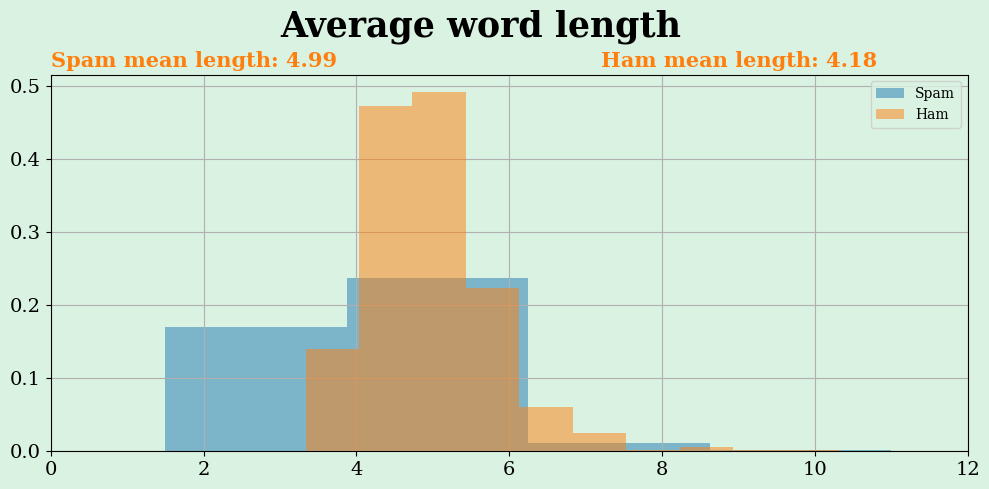

In [13]:
def mean_word_length(word_list):
    return np.array([len(word) for word in word_list]).mean()
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_ham['FullMessage'].str.split().apply(mean_word_length),
        density=True, alpha=0.5, color=blue, bins=20, label='Spam')
ax.hist(df_spam['FullMessage'].str.split().apply(mean_word_length),
        density=True, alpha=0.5, color=orange, zorder=3, bins=20, label='Ham')
ax.legend()
ax.set_xlim(0, 12)
ax.text(0.25, 1.10, 'Average word length',
       transform = ax.transAxes, size=25, fontweight='bold')
ax.text(0.6, 1.02, f'Ham mean length: '
                        f'{df_ham["FullMessage"].str.split().apply(mean_word_length).mean().round(2)}',
             transform = ax.transAxes, size=15, fontweight='bold',
             color=orange)
ax.text(0.0, 1.02, f'Spam mean length: {df_spam["FullMessage"].str.split().apply(mean_word_length).mean().round(2)}',
             transform = ax.transAxes, size=15, fontweight='bold',
             color=orange)
plt.tight_layout()
plt.show()

## Favourite stopwords used

In [14]:
from nltk.corpus import stopwords
sw = set(stopwords.words("english"))

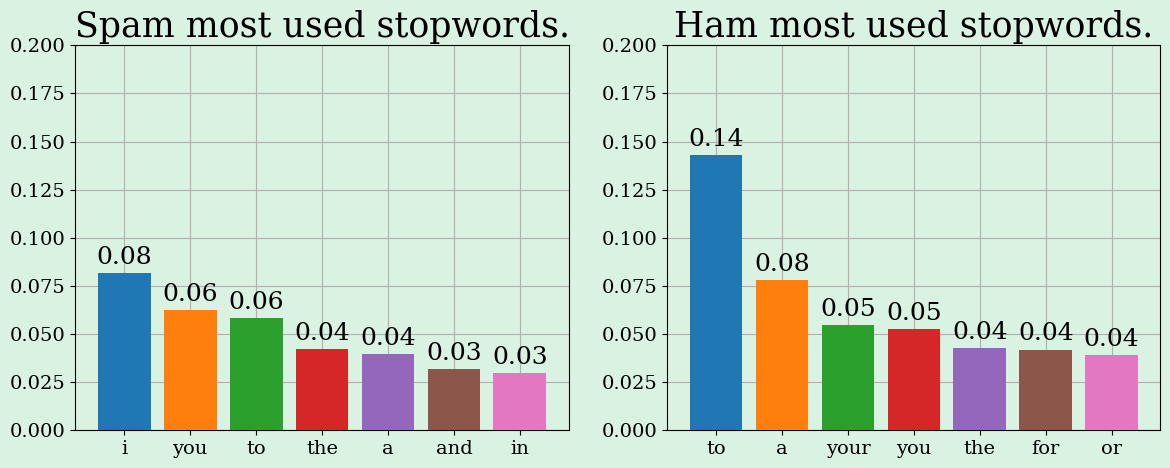

In [15]:
ham_corpus = pd.Series([word for sms in df_ham['FullMessage'].str.lower() for word in
                        sms.split()  if word in sw])
ham_counts = ham_corpus.value_counts(normalize=True)
spam_corpus = pd.Series([word for sms in df_spam['FullMessage'].str.lower() for word in
                        sms.split()  if word in sw])
spam_counts = spam_corpus.value_counts(normalize=True)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
rects = axes[0].bar(ham_counts.index[:7], ham_counts.values[:7],
                zorder=3, color=cm.tab10.colors)
autolabel(rects, axes[0])
axes[0].set_title('Spam most used stopwords.')
axes[0].set_ylim(0, 0.2)

rects = axes[1].bar(spam_counts.index[:7], spam_counts.values[:7],
                zorder=3, color=cm.tab10.colors)
autolabel(rects, axes[1])
axes[1].set_title('Ham most used stopwords.')
axes[1].set_ylim(0, 0.2)
plt.show()

## Favourite non-stopwords used

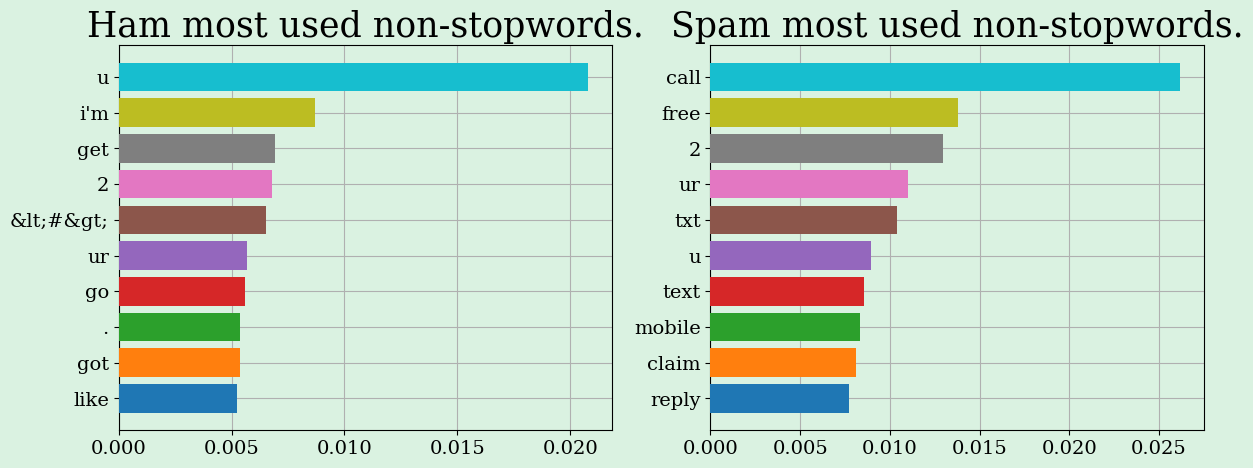

In [16]:
ham_corpus = pd.Series([word for sms in df_ham['FullMessage'].str.lower() for word in
                        sms.split() if word not in sw])
ham_counts = ham_corpus.value_counts(normalize=True).sort_values()[-10:]
spam_corpus = pd.Series([word for sms in df_spam['FullMessage'].str.lower() for word in
                        sms.split() if word not  in sw])
spam_counts = spam_corpus.value_counts(normalize=True).sort_values()[-10:]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
rects = axes[0].barh(ham_counts.index[:10], ham_counts.values[:10],
                zorder=3, color=cm.tab10.colors)
axes[0].set_title('Ham most used non-stopwords.')
rects = axes[1].barh(spam_counts.index[:10], spam_counts.values[:10],
                zorder=3, color=cm.tab10.colors)
axes[1].set_title('Spam most used non-stopwords.')
plt.show()

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;">Step 1 results:</h2>

1. Classes are imbalanced.
2. There are technical symbols in the data, they need to be taken care of.
3. Spam messages contain some obvious spam words - **'call'**, **'free'**,
**'claim'**.
4. Spam messages are usually longer than non-spam both in terms of words and
symbols.

<div id="step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Establish baseline. </span>

# Function to check the results.

In [17]:
def results(y_test, y_hat, average=None):
    from sklearn.metrics import confusion_matrix, classification_report, \
        accuracy_score, recall_score, precision_score, f1_score

    unique_y = sorted(y_test.unique())
    if average is None:
        if len(unique_y) == 2:
            average = 'binary'
        else:
            average = 'weighted'
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Overall metrics
    accuracy = accuracy_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat, average=average,pos_label='spam')
    precision = precision_score(y_test, y_hat, average=average,
                                pos_label="spam")
    f1 = f1_score(y_test, y_hat, average=average, pos_label="spam")
    fig.text(0.4, 1.2, f'Accuracy: {accuracy:.3f} ',
                 va='top', size=30)
    fig.text(0.3, 1.05,
             f'Recall: {recall:.3f} Precision: {precision:.3f} F1: {f1:.3f} ',
             va='bottom', size=20)
    value_counts = (y_test == y_hat).value_counts()
    fig.text(0.35, 0.95,f'Total correct: {value_counts[True]} Total incorrect:'
                       f' {value_counts[False]}', fontsize=20)

    # Classification report
    cr = classification_report(y_test, y_hat, output_dict=True)
    sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, annot=True, ax=axes[0],
                cmap='YlGnBu')
    axes[0].set_xlabel('Metrics', fontsize=20)
    axes[0].set_ylabel('Classes', fontsize=20)
    axes[0].set_title('Classification report', fontsize=20)

    # Confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_hat), columns=unique_y,
                      index=unique_y)
    sns.heatmap(cm, annot=True, ax=axes[1], cmap='YlGnBu', fmt='.0f')
    axes[1].set_xlabel('Predicted', fontsize=20)
    axes[1].set_ylabel('Actual', fontsize=20)
    axes[1].set_title('Confusion matrix', fontsize=20)
    plt.show()
    return accuracy

## Establish baseline:
 * Encoding - Count Vectorizer.
 * Preprocessing - MinMaxScaler.
 * No feature engineering.
 * Simple model - Logistic Regression.
 * 5 fold cross-validation.


In [18]:
cv = KFold(shuffle=True, n_splits=5, random_state=0)

In [19]:
def update_scores(score_df, model_name, score):
    model_dict = dict()
    model_dict['ModelName'] = model_name
    model_dict['Score'] = score
    if model_name not in score_df['ModelName'].values:
        score_df = score_df.append(model_dict, ignore_index=True)
    else:
        index = score_df[score_df['ModelName'] == model_name].index[0]
        score_df.at[index, 'Score'] = score
    return score_df

In [20]:
def create_score_df():
    # Create a DataFrame with scores
    score_df = pd.DataFrame(columns=['ModelName', 'Score'])
    return score_df

score_df = create_score_df()

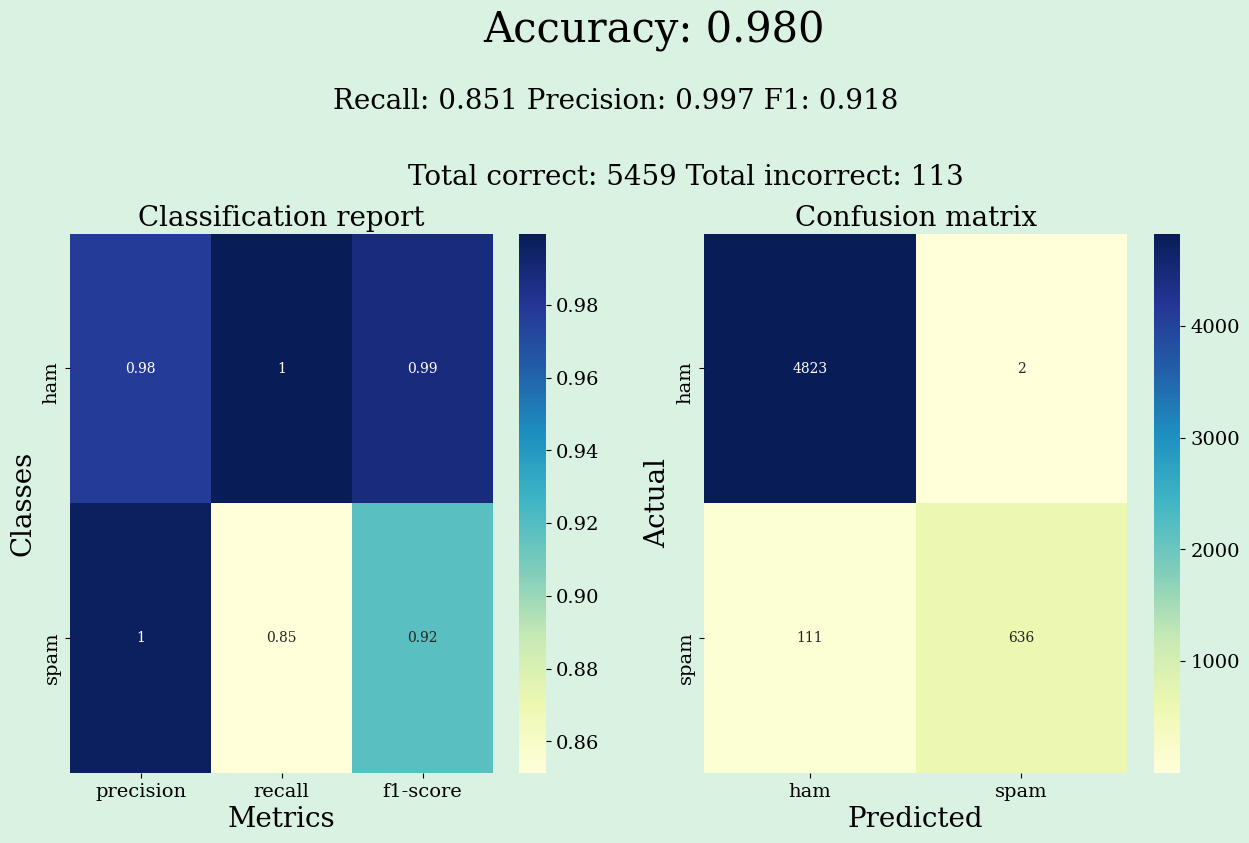

In [21]:
X = df[['FullMessage']]
y = df['Label']

transformers = [('vectorizer', CountVectorizer(), 'FullMessage')]
ct = ColumnTransformer(transformers, remainder='passthrough',
                       sparse_threshold=0)
steps = [('Vectorize', ct),
         ('Scale', MinMaxScaler()),
         ('Model', LogisticRegression())]
pipeline = Pipeline(steps)

baseline_preds = cross_val_predict(pipeline, X, y, cv=cv)
baseline_score = results(y, baseline_preds)
score_df = update_scores(score_df, 'Baseline', baseline_score)

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;">Step 2 results:</h2>

1. Out of the box Logistic regression with no preprocessign shows very
 good result.
2. The main cause of the mistakes - False Negatives. Algorithm thinks message
 is ham, but actually it is spam. Need to add some spam-specific markers.
3. Need to use preprocessing and feature engineering to beat baseline score.

<div id="step3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 3. Preprocess data. </span>

## Find and replace special symbols

In [22]:
df['MessageCleared'] = df['FullMessage']

def special_symbols(series):
    special_symbols = series.str.findall('[^A-Za-z0-9 .,\"\'?!£;:-]')
    special_symbol_counts = \
        pd.Series([symbol_part for symbol in special_symbols for symbol_part in
                   symbol]).value_counts()
    return special_symbol_counts

special_symbol_counts = special_symbols(df['MessageCleared'])
special_symbol_counts[:5]

&    922
)    499
/    419
å    382
\    351
dtype: int64

In [23]:
df['MessageCleared'] = \
    df['MessageCleared'].str.replace(
        '(&lt;#&gt;)|(&lt;DECIMAL&gt)', 'PersonalData', regex=True)
df['MessageCleared'] = \
    df['MessageCleared'].str.replace('&lt;TIME&gt;', 'TimeData', regex=True)
df['MessageCleared'] = \
    df['MessageCleared'].str.replace('&lt;URL&gt;', 'UrlData', regex=True)
df['MessageCleared'] = \
    df['MessageCleared'].str.replace('&amp;', 'and', regex=True)
df['MessageCleared'] = \
    df['MessageCleared'].str.replace(':\)', 'SmileSymbol', regex=True)
df['MessageCleared'] = \
    df['MessageCleared'].str.replace(':\(', 'SadSmileSymbol', regex=True)
df['MessageCleared'] = \
    df['MessageCleared'].str.replace('&lt;3', 'LoveYouSymbol', regex=True)

# Remove problem with a pound sign

In [24]:
df['MessageCleared'] = \
    df['MessageCleared'].str.replace('å£', '£', regex=True)

In [25]:
special_symbol_counts = special_symbols(df['MessageCleared'])
special_symbol_counts[:5]

/    419
\    351
*    311
)    248
&    213
dtype: int64

### Exclude some of the Spacy's pipeline steps to improve speed.

In [26]:
nlp = spacy.load('en_core_web_lg',
                 exclude=['tagger', 'parser', 'lemmatizer', 'attribute_ruler'])

In [27]:
df['NLP'] = df['MessageCleared'].apply(nlp)
df['NLP'].head()

0                                                      (Go, until, jurong, point, ,, crazy, .., Available, only, in, bugis, n, great, world, la, e, buffet, ..., Cine, there, got, amore, wat, ...)
1                                                                                                                                                          (Ok, lar, ..., Joking, wif, u, oni, ...)
2    (Free, entry, in, 2, a, wkly, comp, to, win, FA, Cup, final, tkts, 21st, May, 2005, ., Text, FA, to, 87121, to, receive, entry, question(std, txt, rate)T&C, 's, apply, 08452810075over18, 's)
3                                                                                                                                 (U, dun, say, so, early, hor, ..., U, c, already, then, say, ...)
4                                                                                                                   (Nah, I, do, n't, think, he, goes, to, usf, ,, he, lives, around, here, though)
Name: NLP, dtype: ob

### Terms and conditions - definitely spam

In [28]:
added_features = []
df[df['MessageCleared'].str.findall('T[erms]*[\ ]*&[\ ]*C').apply(len) > 0]['Label'].value_counts()

spam    63
Name: Label, dtype: int64

In [29]:
df['T&C'] = \
    df['MessageCleared'].str.findall('T[erms]*[\ ]*&[\ ]*C').apply(len) > 0
added_features.append('T&C')
df[df['T&C'] == True][['MessageCleared', 'T&C']].head()

,MessageCleared,T&C
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,True
12,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18",True
295,T-Mobile customer you may now claim your FREE CAMERA PHONE upgrade & a pay & go sim card for your loyalty. Call on 0845 021 3680.Offer ends 28thFeb.T&C's apply,True
311,"Think ur smart ? Win £200 this week in our weekly quiz, text PLAY to 85222 now!T&Cs WinnersClub PO BOX 84, M26 3UZ. 16+. GBP1.50/week",True
417,FREE entry into our £250 weekly competition just text the word WIN to 80086 NOW. 18 T&C www.txttowin.co.uk,True


## Whether a message contains a phone number.

In [30]:
matcher = Matcher(nlp.vocab)
pattern1 = [{'TEXT': {"REGEX":'\d{11}'}},]
pattern2 = [{'TEXT': {"REGEX":'\d{10}'}},]
pattern3 = [{'TEXT': {"REGEX": r'^\d{5}$'}},]
pattern4 = [
    {'SHAPE': 'dddd'},  {"IS_PUNCT": True}, {'SHAPE': 'ddd'},
    {"IS_PUNCT": True}, {'SHAPE': 'dddd'}]
pattern5 = [{'TEXT': {"REGEX": r'[\d]{4}'}}, {'TEXT': {"REGEX": r'[\d]{3}'}},
            {'TEXT': {"REGEX": r'[\d]{3}'}}]
pattern6 = [
    {'SHAPE': 'dddd'},  {"IS_PUNCT": True}, {'SHAPE': 'dddd'},
    {"IS_PUNCT": True}, {'SHAPE': 'ddd'}]
pattern7 = [{'TEXT': {"REGEX":'[\d]{4} [\d]{6}'}},]

matcher.add('PHONE_NUMBER',
            [pattern1, pattern2, pattern3, pattern4, pattern5, pattern7])

df['PhoneNumber'] = \
    df['NLP'].apply(matcher).apply(len) > 0
added_features.append('PhoneNumber')
df[df['PhoneNumber'] == True][['MessageCleared', 'PhoneNumber']].head()

,MessageCleared,PhoneNumber
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,True
8,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,True
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,True
11,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",True
12,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18",True


## Length of a message

In [31]:
df['LengthInSymbols'] = df['MessageCleared'].apply(len)
added_features.append('LengthInSymbols')
df['LengthInSymbols']

0       111
1        29
2       155
3        49
4        61
       ... 
5567    160
5568     37
5569     57
5570    125
5571     26
Name: LengthInSymbols, Length: 5572, dtype: int64

In [32]:
df['LengthInWords'] = df['MessageCleared'].str.split().apply(len)
added_features.append('LengthInWords')
df['LengthInWords']

0       20
1        6
2       28
3       11
4       13
        ..
5567    30
5568     8
5569    10
5570    26
5571     6
Name: LengthInWords, Length: 5572, dtype: int64

In [33]:
df[['MessageCleared', 'LengthInSymbols', 'LengthInWords']].head()

,MessageCleared,LengthInSymbols,LengthInWords
0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,20
1,Ok lar... Joking wif u oni...,29,6
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,28
3,U dun say so early hor... U c already then say...,49,11
4,"Nah I don't think he goes to usf, he lives around here though",61,13


## Named entities

In [34]:
df['NamedEntities'] = df['NLP'].apply(lambda x: [ent.label_ for ent in x.ents])
df[df['NamedEntities'].apply(len) > 0][['MessageCleared', 'NamedEntities']].head()

,MessageCleared,NamedEntities
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,"[CARDINAL, WORK_OF_ART, DATE]"
4,"Nah I don't think he goes to usf, he lives around here though",[ORG]
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv","[DATE, MONEY, ORG]"
7,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,"[PERSON, PERSON, CARDINAL, PERSON]"
8,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,"[PERSON, TIME]"


## Money in the message (prices)

In [35]:
# matcher = Matcher(nlp.vocab)
# pattern1 = [{'TEXT': {'REGEX': r'[0-9]+[p][\.]?'}},]
# matcher.add('Money', [pattern1])
#
# df['Money'] = df['NamedEntities'].apply(lambda x: 'MONEY' in x) | \
#               df['FullMessage'].str.contains('£') | \
#               df['NLP'].apply(matcher).apply(len) > 0

matcher = Matcher(nlp.vocab)
# '120p.' '120p' '120 p' '120 p.'
pattern1 = [{'TEXT': {'REGEX': r'[0-9]+[ ]?[p][\.]?'}},]
# '120gbp.' '120gbp' '120 gbp' '120 gbp.'
pattern2 = [{'TEXT': {'REGEX': r'[0-9]+[ ]?gbp[\.]?'}},]
# '100 G.B.' '100G.B.'
pattern3 = [{'TEXT': {'REGEX': r'[0-9]+[ ]?G.B.[\.]??'}},]

matcher.add('Money', [pattern1, pattern2, pattern3])

df['Money'] = df['NamedEntities'].apply(lambda x: 'MONEY' in x) | \
              df['FullMessage'].str.contains('£') | \
              df['NLP'].apply(matcher).apply(len) > 0
df[df['Money'] == True][['MessageCleared', 'Money']].head()
added_features.append('Money')
df[df['Money'] == True][['MessageCleared', 'Money']].head()


,MessageCleared,Money
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",True
8,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,True
11,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",True
12,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18",True
34,Thanks for your subscription to Ringtone UK your mobile will be charged £5/month Please confirm by replying YES or NO. If you reply NO you will not be charged,True


## Dates, events or products in the message

In [36]:
df['Date'] = df['NamedEntities'].apply(lambda x: 'DATE' in x)
added_features.append('Date')
df['Event'] = df['NamedEntities'].apply(lambda x: 'EVENT' in x)
added_features.append('Event')
df['Product'] = df['NamedEntities'].apply(lambda x: 'PRODUCT' in x)
added_features.append('Product')
filter = (df['Date'] == True) | (df['Event'] == True) | (df['Product'] == True)
df[filter][['MessageCleared', 'NamedEntities', 'Date', 'Event', 'Product']].head()

,MessageCleared,NamedEntities,Date,Event,Product
2,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,"[CARDINAL, WORK_OF_ART, DATE]",True,False,False
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv","[DATE, MONEY, ORG]",True,False,False
9,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,"[DATE, CARDINAL]",True,False,False
10,"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.","[TIME, DATE]",True,False,False
11,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info","[CARDINAL, QUANTITY, CARDINAL, DATE, CARDINAL, PERSON, CARDINAL]",True,False,False


## Website addresses in the message

In [37]:
matcher = Matcher(nlp.vocab)
pattern1 = [{'TEXT': {"REGEX": r'(http:)'}},]
pattern2 = [{'TEXT': {"REGEX": r'([w|W]{3}.)'}},]
pattern3 = [{'TEXT': {"REGEX": r'(\.(com))'}},]
pattern4 = [{'TEXT': {"REGEX": r'(\.(net))'}},]
pattern5 = [{'TEXT': {"REGEX": r'(\.(biz))'}},]
matcher.add('SITE', [pattern1, pattern2, pattern3, pattern4, pattern5])
df['Site'] = df['NLP'].apply(matcher).apply(len) > 0
added_features.append('Site')
df[df['Site'] == True][['MessageCleared', 'Site']].head()

,MessageCleared,Site
12,"URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18",True
15,"XXXMobileMovieClub: To use your credit, click the WAP link in the next txt message or click here>> http://wap. xxxmobilemovieclub.com?n=QJKGIGHJJGCBL",True
135,I only haf msn. It's yijue@hotmail.com,True
163,-PLS STOP bootydelious (32/F) is inviting you to be her friend. Reply YES-434 or NO-434 See her: www.SMS.ac/u/bootydelious STOP? Send STOP FRND to 62468,True
190,Are you unique enough? Find out from 30th August. www.areyouunique.co.uk,True


## Uppercase words in the message

In [38]:
matcher = Matcher(nlp.vocab)
pattern1 = [{'TEXT': {"REGEX":'[A-Z]{2,}'}},]
matcher.add('UppercaseWords', [pattern1])
df['UppercaseWords'] = df['NLP'].apply(matcher).apply(len) > 0
df['UppercaseWordsCount'] = df['NLP'].apply(matcher).apply(len)
added_features.append('UppercaseWords')
added_features.append('UppercaseWordsCount')

## Repeated punctuation signs in the message

In [39]:
df['RepeatedPunctuation'] = \
    df['MessageCleared'].str.findall('[\!]{2,}').apply(len) > 0
added_features.append('RepeatedPunctuation')
df[df['RepeatedPunctuation'] == True][['MessageCleared',
                                       'RepeatedPunctuation']].head()

,MessageCleared,RepeatedPunctuation
8,WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.,True
14,I HAVE A DATE ON SUNDAY WITH WILL!!,True
92,Smile in Pleasure Smile in Pain Smile when trouble pours like Rain Smile when sum1 Hurts U Smile becoz SOMEONE still Loves to see u Smiling!!,True
115,"As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there.",True
206,"As I entered my cabin my PA said, '' Happy B'day Boss !!''. I felt special. She askd me 4 lunch. After lunch she invited me to her apartment. We went there.",True


## Merge txt and text into one word

In [40]:
df['MessageCleared'] = \
    df['MessageCleared'].str.replace('(TXT)|(txt)|(Txt)', 'text')

## Check the proportion of classes with each new feature with stacked bar charts

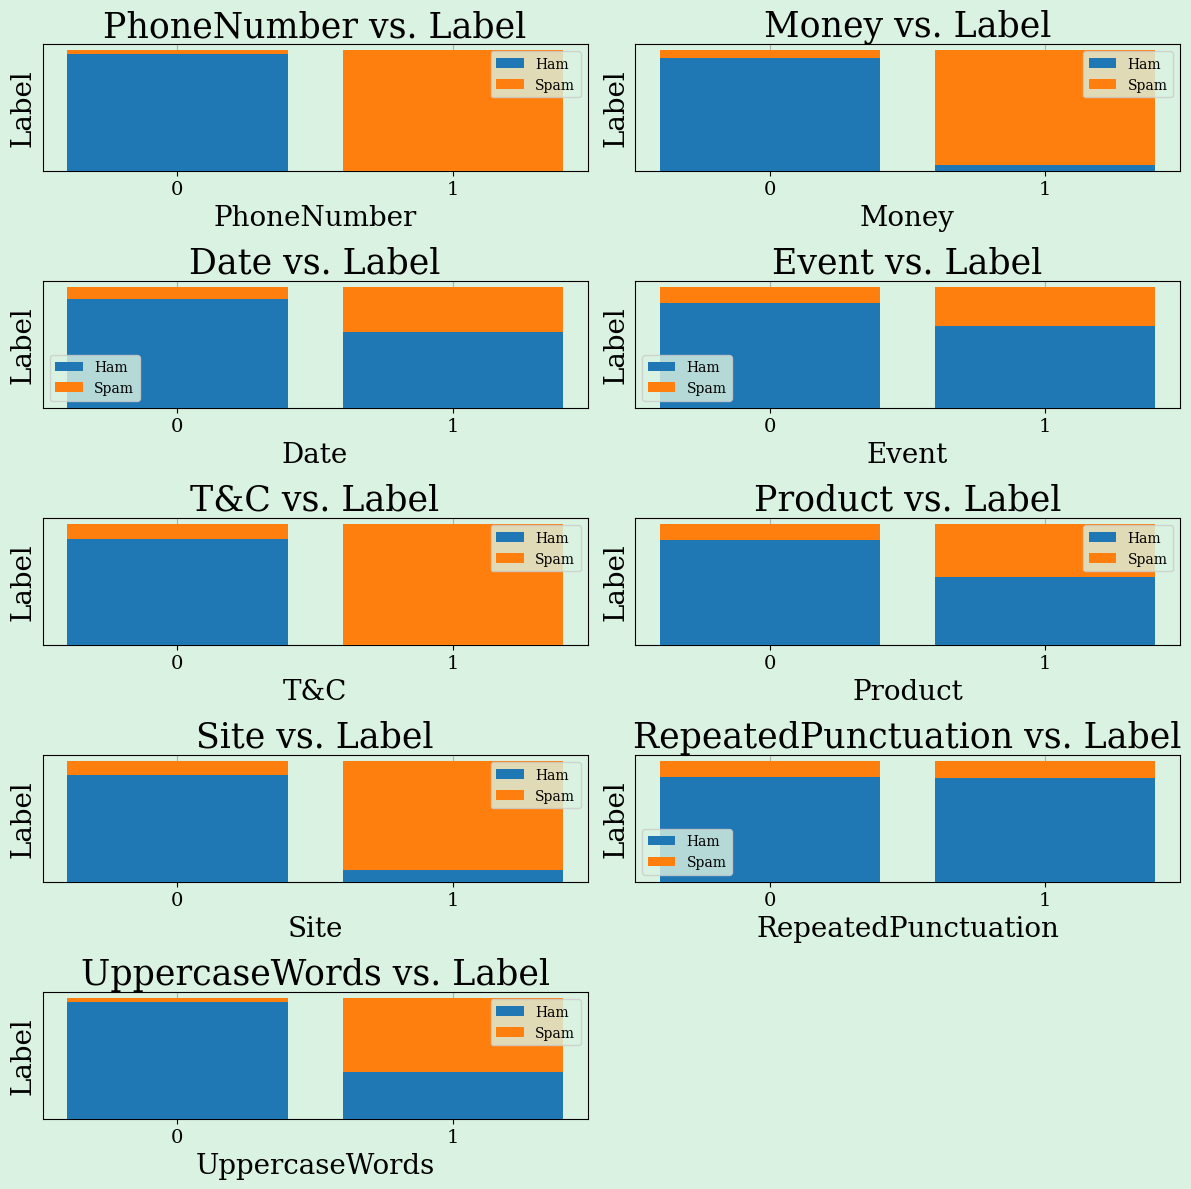

In [41]:
def categorical_plot(df, new_categorical_features, dependent_variable,
                     vertical_classes):
    bottom = 0
    n_columns = 2
    n_rows = int(np.ceil(len(new_categorical_features) / 2))
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(12, 12))
    for feature, ax in zip(new_categorical_features, axes.ravel()):
        crosstab = pd.crosstab(df[feature], df[dependent_variable],
                               normalize='index')
        crosstab.reset_index(inplace=True)
        crosstab.columns = [feature]  + vertical_classes

        for index, vertical_class in enumerate(vertical_classes):
            ax.bar(crosstab[feature], crosstab[vertical_class],
                        label=vertical_class, color=cm.tab10.colors[index],
                        zorder=3, bottom=bottom)
            bottom += crosstab[vertical_class]
        ax.set_xlabel(feature, size=20)
        ax.set_ylabel(dependent_variable, size=20)
        ax.set_xticks(crosstab[feature])
        ax.set_yticks([])
        ax.set_title(f'{feature} vs. {dependent_variable}')
        ax.legend()
    if len(new_categorical_features) < len(axes.ravel()):
        last_ax = axes.ravel()[-1]
        last_ax.axis('off')
    plt.tight_layout()
    plt.show()

new_categorical_features = ['PhoneNumber', 'Money', 'Date', 'Event', 'T&C',
                            'Product', 'Site', 'RepeatedPunctuation',
                            'UppercaseWords']
categorical_plot(df, new_categorical_features, dependent_variable,
                 vertical_classes=['Ham', 'Spam'])

# Score only new features with Logistic Regression

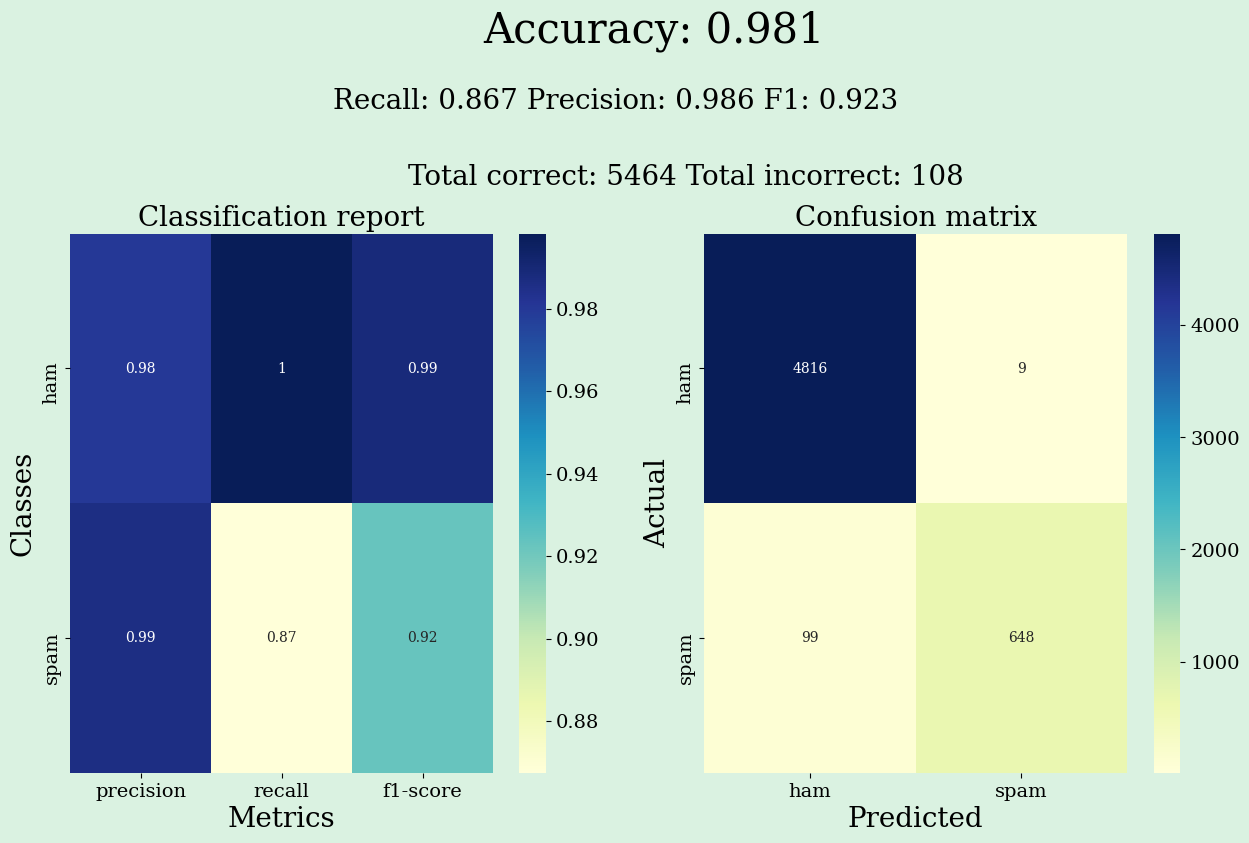

In [42]:
X = df[added_features]
y = df['Label']
steps = [('Scale', MinMaxScaler()),
         ('Model', LogisticRegression())]
pipeline = Pipeline(steps)
new_features_preds = cross_val_predict(pipeline, X, y, cv=cv)
new_features_score = results(y, new_features_preds)
score_df = update_scores(score_df, 'Only new features', new_features_score)

<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;">Step 3 results:</h2>

1. Created some nice features that can help distinguish classes:
    * PhoneNumber
    * Site
    * T&C
    * Money
2. Also created some bad features:
    * RepeatedPunctuation
    * Label
3. New features allow classifying SMS at the level of a baseline.

<div id="step4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 4. Choose model. </span>

# Score new features and vectorized SMS text with Logistic Regression

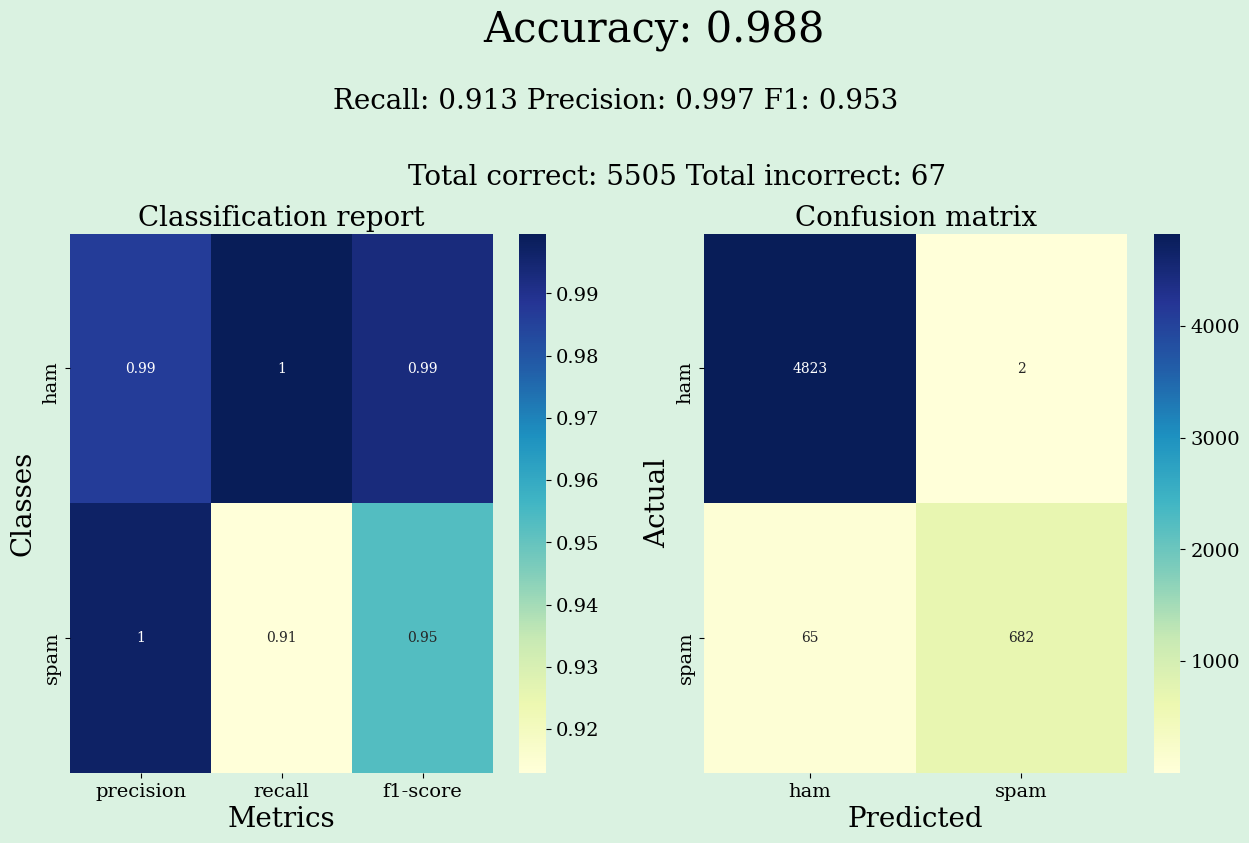

In [43]:
X = df[['MessageCleared'] + added_features]
y = df['Label']

transformers = [('vectorizer', CountVectorizer(), 'MessageCleared')]
ct = ColumnTransformer(transformers, remainder='passthrough',
                       sparse_threshold=0)
steps = [('Vectorize', ct),
         ('Scale', MinMaxScaler()),
         ('Model', LogisticRegression())]
pipeline = Pipeline(steps)

text_new_features_preds = cross_val_predict(pipeline, X, y, cv=cv)
text_new_features_proba = cross_val_predict(pipeline, X, y, cv=cv,
                                            method='predict_proba')
text_new_features_score = results(y, text_new_features_preds)
score_df = update_scores(score_df, 'Text + new features', text_new_features_score)

# Check the most important features

In [44]:
pipeline.fit(X, y)
coefs = pipeline.steps[2][1].coef_[0]

columns = X.columns.tolist()
columns.remove('MessageCleared')
feature_names = \
    pipeline.steps[0][1].transformers_[0][1].get_feature_names() + columns

importance_series =\
    pd.Series(coefs, feature_names).apply(np.abs).sort_values(ascending=False)
importance_series.round(3)
print(f'Total number of features: {len(feature_names)}')

Total number of features: 8893


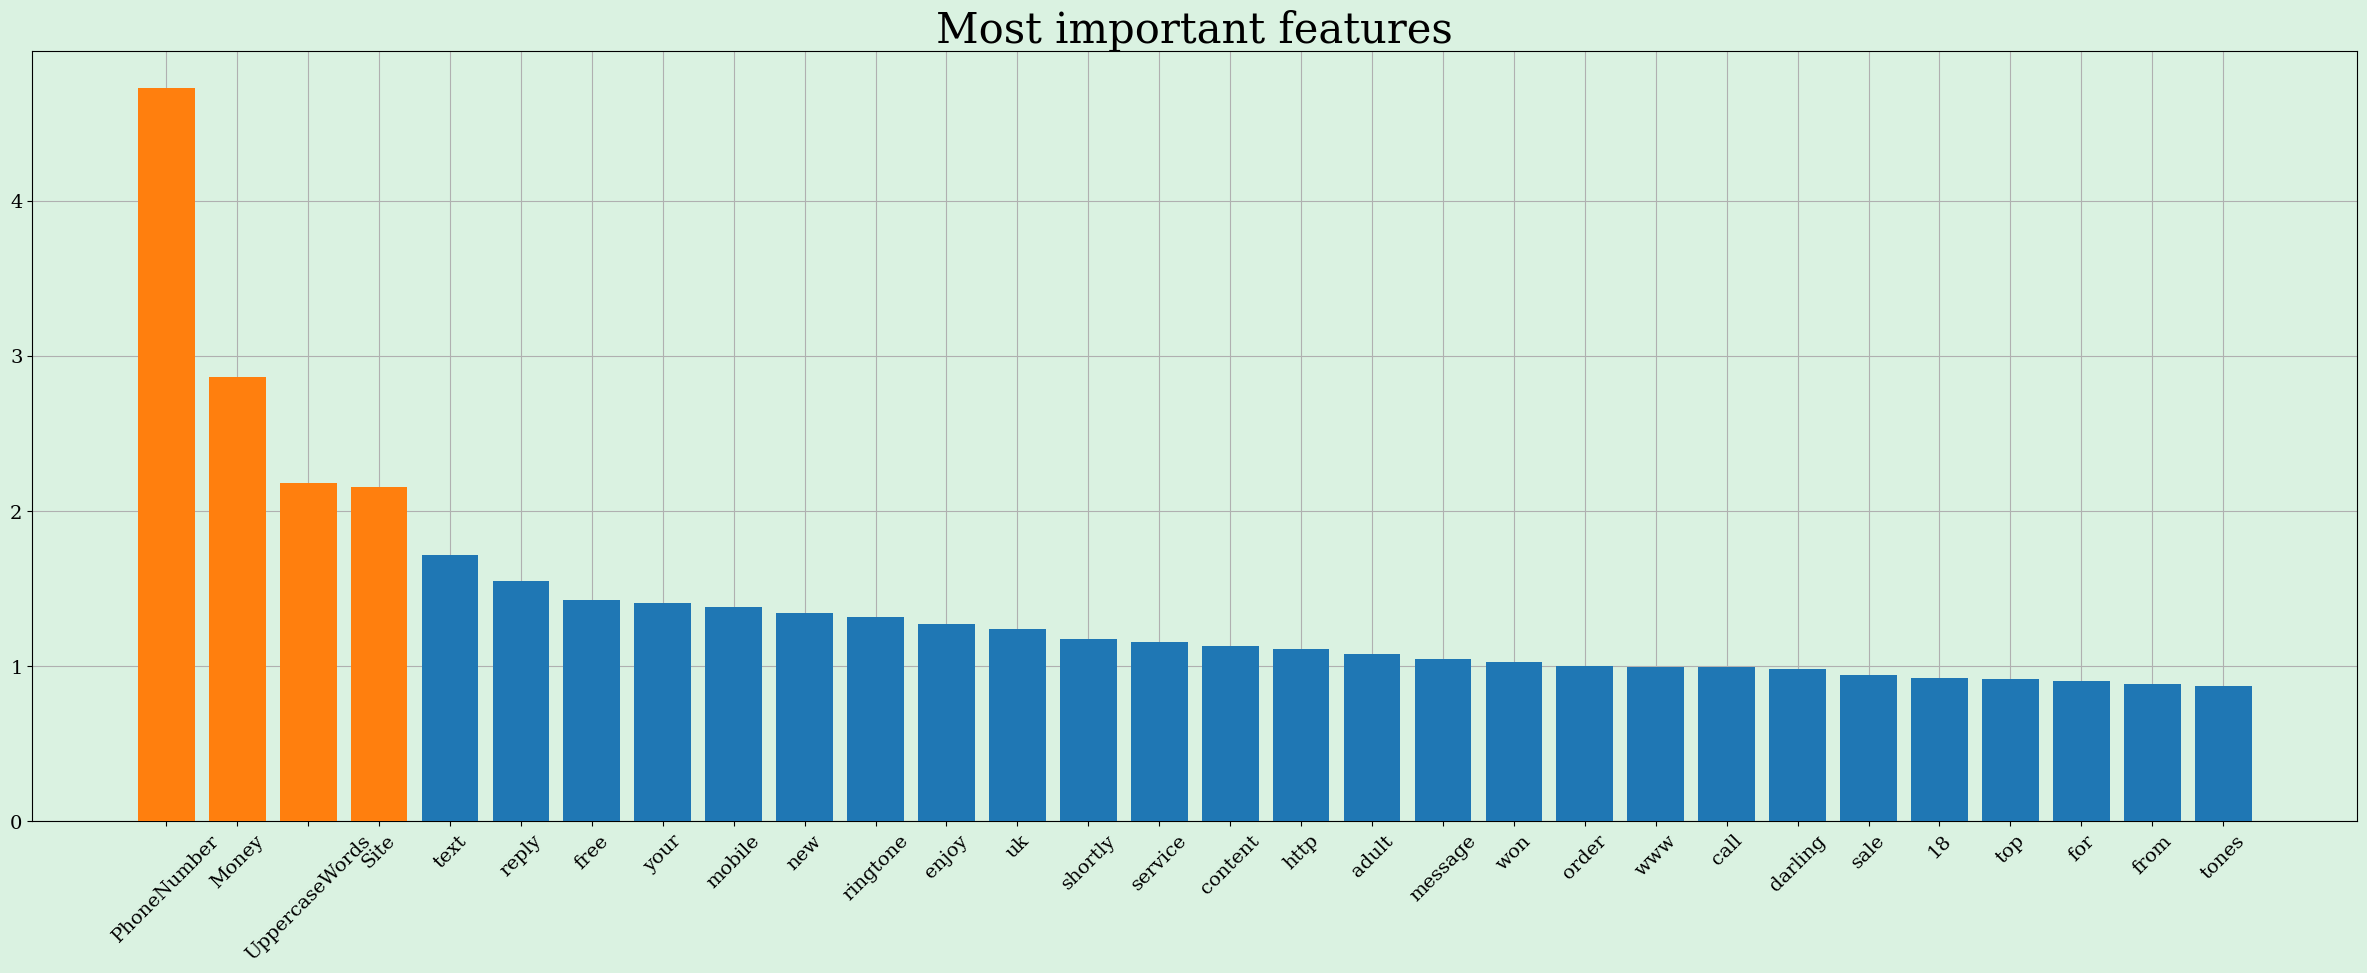

In [45]:
def plot_feature_importance(features, n_features=10, added_features=[]):
    fig, ax = plt.subplots(figsize=(30, 10))
    if n_features:
        top_n_features = features[:n_features]
    else:
        top_n_features = features

    ax.bar(top_n_features.index, top_n_features.values,
           color=[orange if feature in added_features else blue for feature in
                  top_n_features.index], zorder=3)
    ax.tick_params(axis='x', rotation=45)
    ax.set_title('Most important features', size=30)
    plt.show()
plot_feature_importance(importance_series, 30, added_features)

## Different preprocessing: Pipelines for CountVectorizer, TfVectorizer and TfidfVectorizer.

In [46]:

def choose_vectorizer(vectorizer_str):
    if vectorizer_str == 'Count':
        vectorizer = CountVectorizer(min_df=5)
    elif vectorizer_str == 'TF':
        vectorizer = TfidfVectorizer(min_df=5, use_idf=False)
    elif vectorizer_str == 'TFIDF':
        vectorizer = TfidfVectorizer(min_df=5, use_idf=True)
    else:
        print('Wrong vectorizer. Terminated.')
        raise ValueError
    return vectorizer

def generate_pipeline(model, vectorizer):
    ct = ColumnTransformer(transformers=[
        ('vectorizer', vectorizer, 'MessageCleared')],
        remainder='passthrough', sparse_threshold=0)

    pipeline = Pipeline(
        steps=[('vectorize', ct),
               ('scale', MinMaxScaler()),
               ('model', model)])

    return pipeline

def generate_predictions(pipeline, proba=False):
    preds = cross_val_predict(pipeline, X, y, cv=cv)
    pred_proba = None
    if proba:
        pred_proba = cross_val_predict(pipeline, X, y, cv=cv,
                                       method='predict_proba')
    return preds, pred_proba

def evaluate_model(model, vectorizer_str='count', model_name=None,
                   score_df=None):

    vectorizer = choose_vectorizer(vectorizer_str)
    if model_name is None:
        # model_name = model.repr() + ' ' + vectorizer_str
        model_name = type(model).__name__ + ' ' + vectorizer_str

    if score_df is None:
        score_df = create_score_df()

    pipeline = generate_pipeline(model, vectorizer)
    preds, pred_proba = generate_predictions(pipeline, proba=False)
    score = results(y, preds)
    score_df = update_scores(score_df, model_name, score)

    return score_df

# Evaluating different models

### Logistic Regression

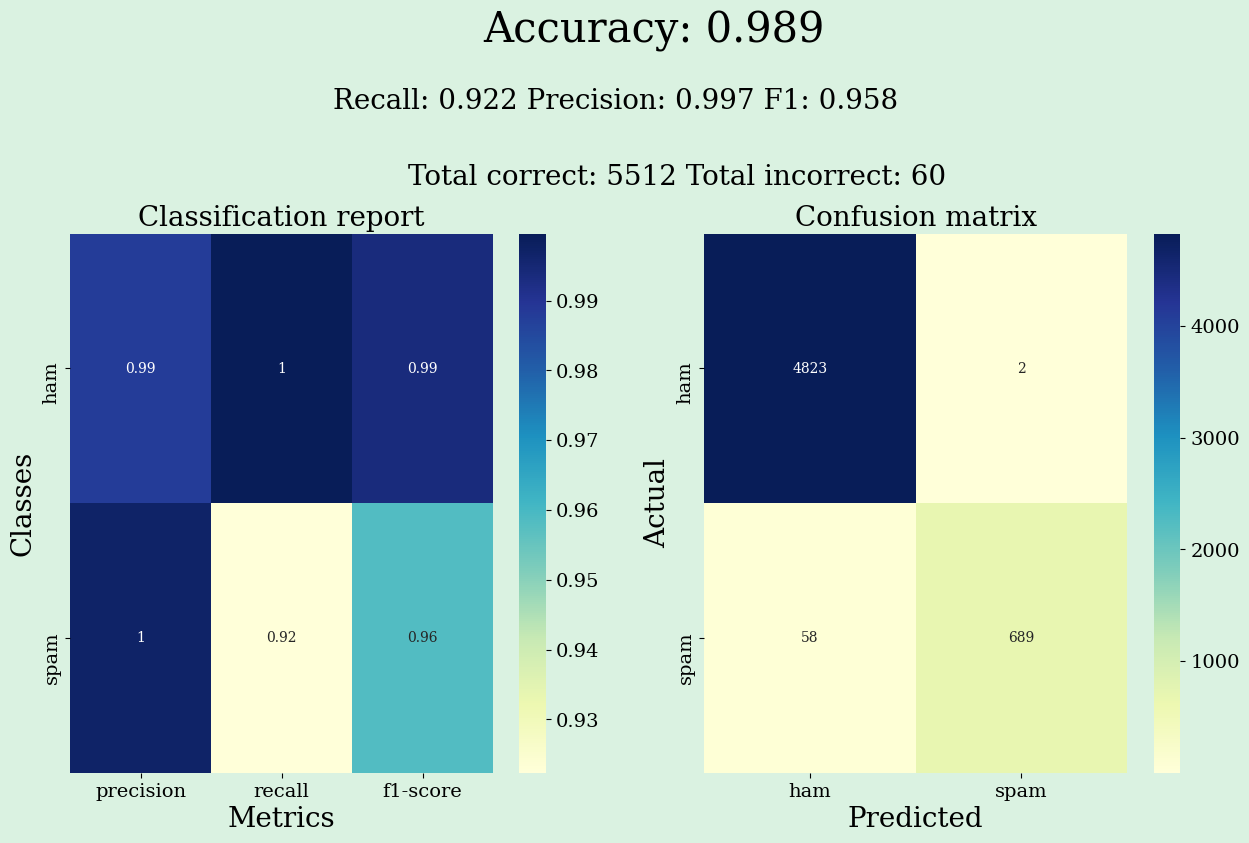

In [47]:
score_df = evaluate_model(LogisticRegression(), vectorizer_str='Count',
                          score_df=score_df)

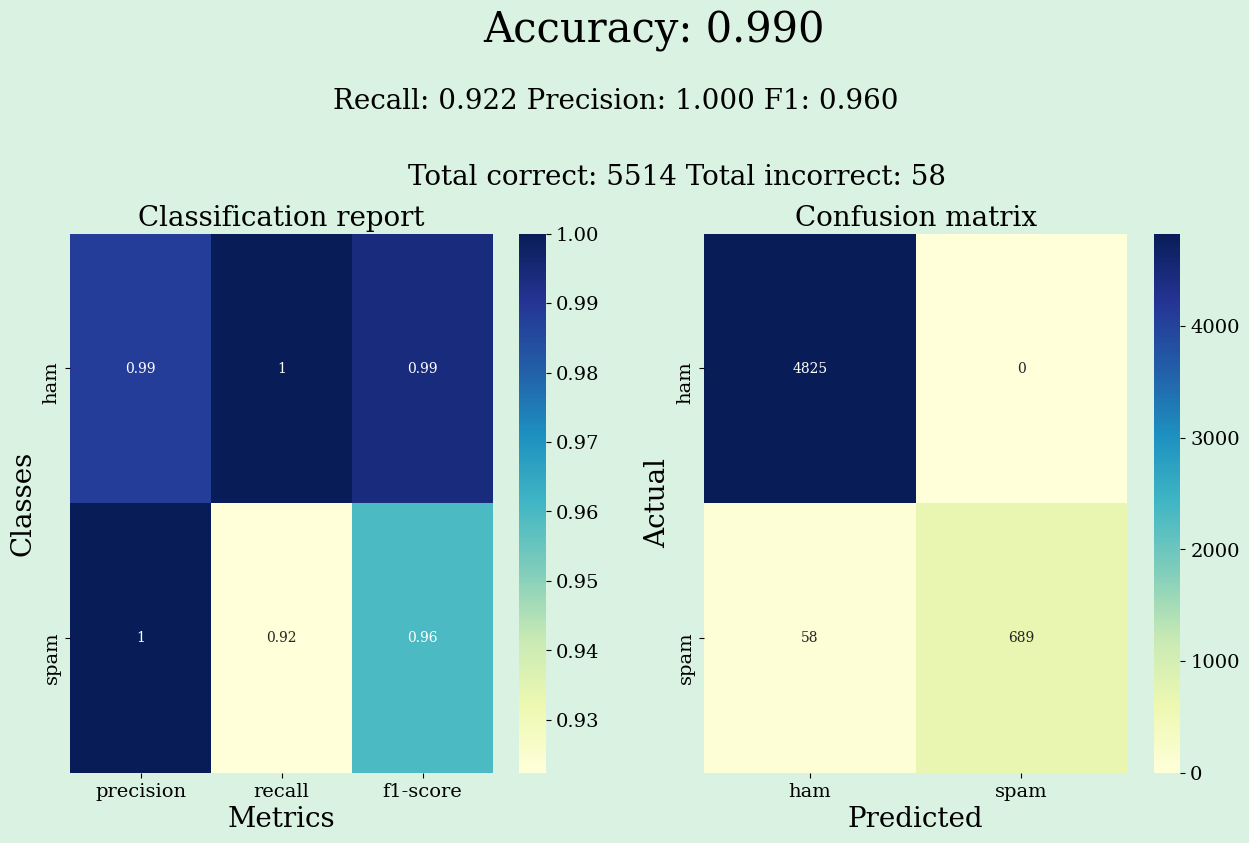

In [48]:
score_df = evaluate_model(LogisticRegression(), vectorizer_str='TF',
                          score_df=score_df)

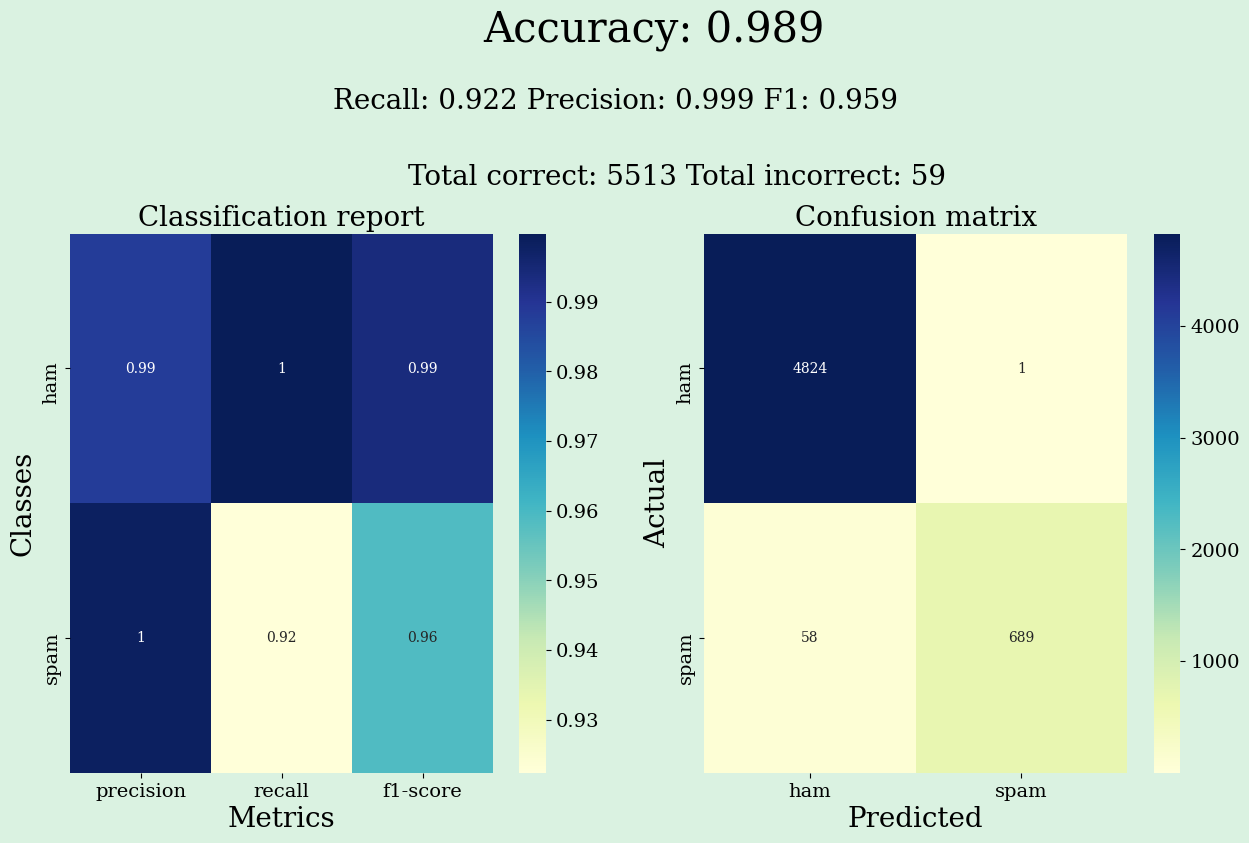

In [49]:
score_df = evaluate_model(LogisticRegression(), vectorizer_str='TFIDF',
                          score_df=score_df)

## Linear SVC

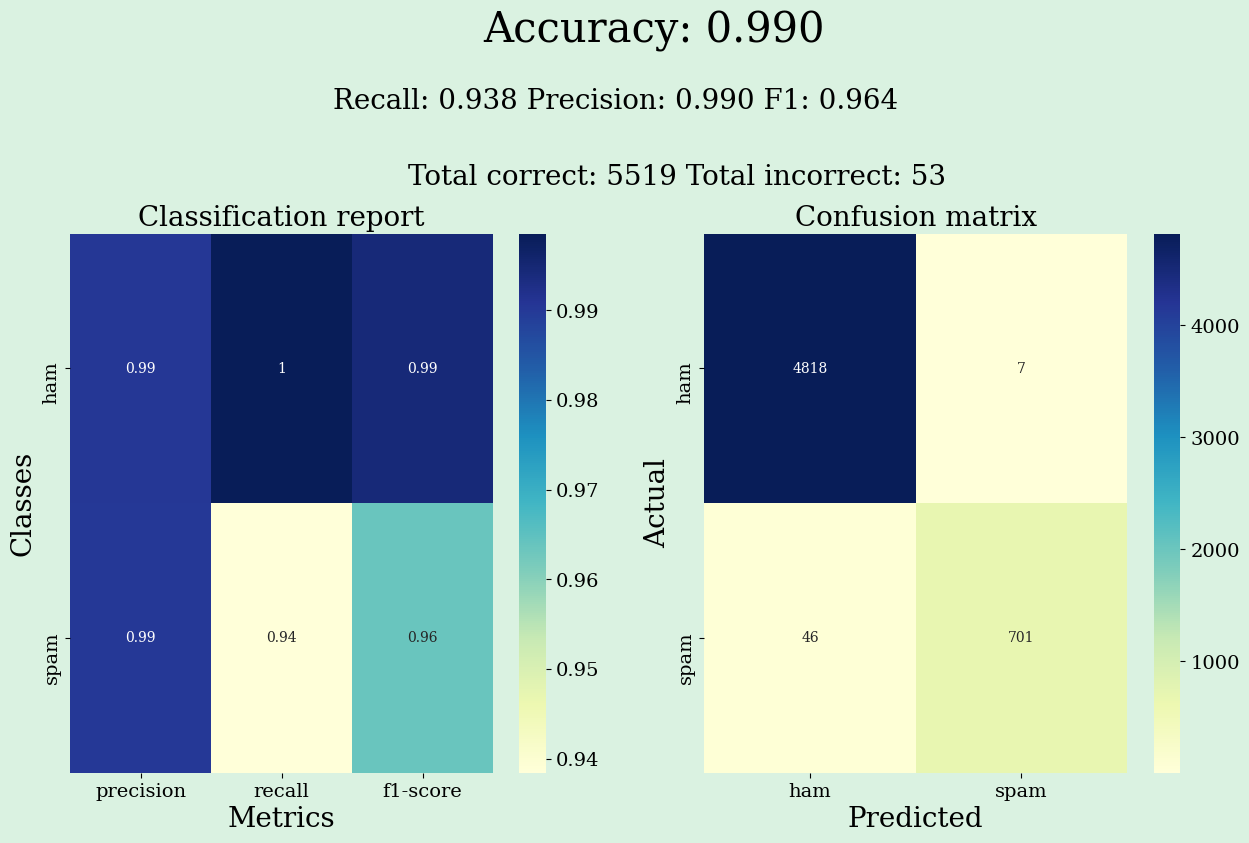

In [50]:
score_df = evaluate_model(LinearSVC(), vectorizer_str='Count',
                          score_df=score_df)

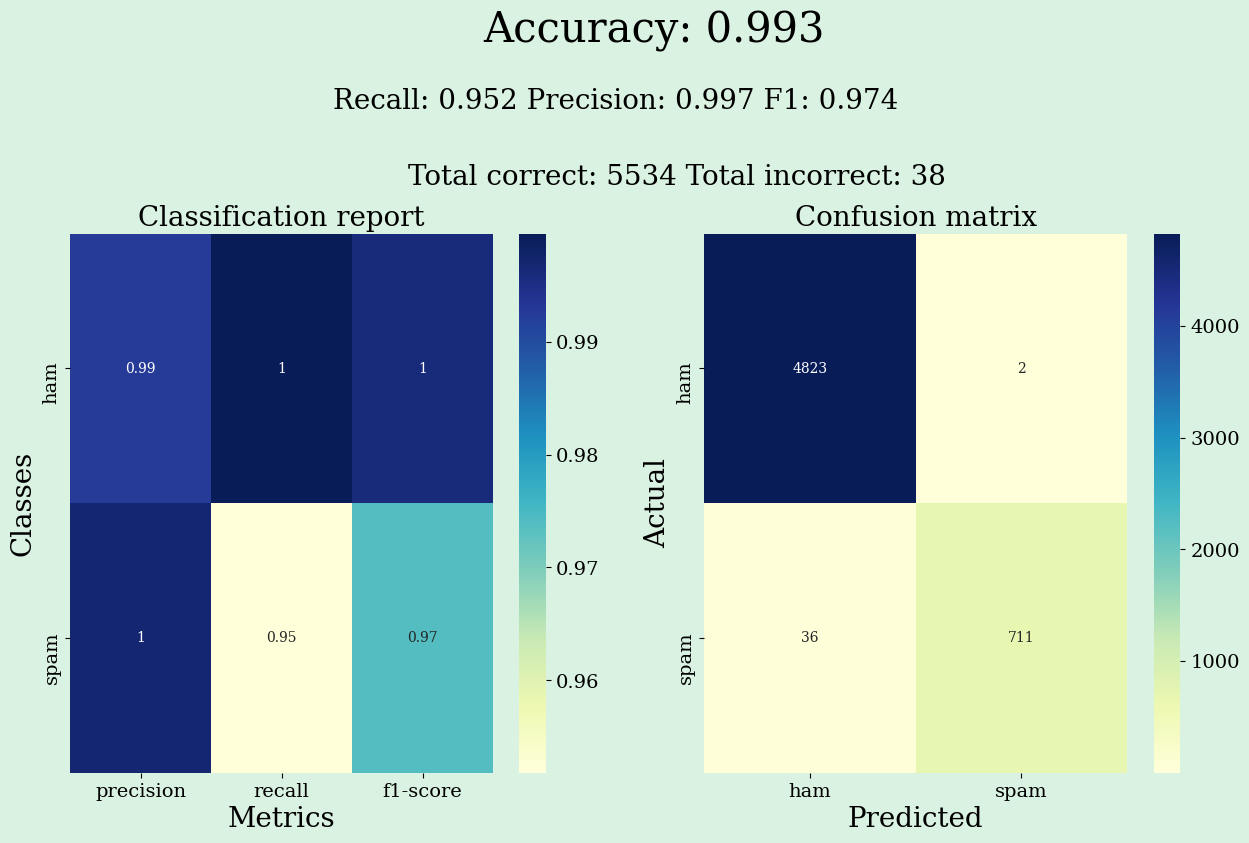

In [51]:
score_df = evaluate_model(LinearSVC(), vectorizer_str='TF',
                          score_df=score_df)

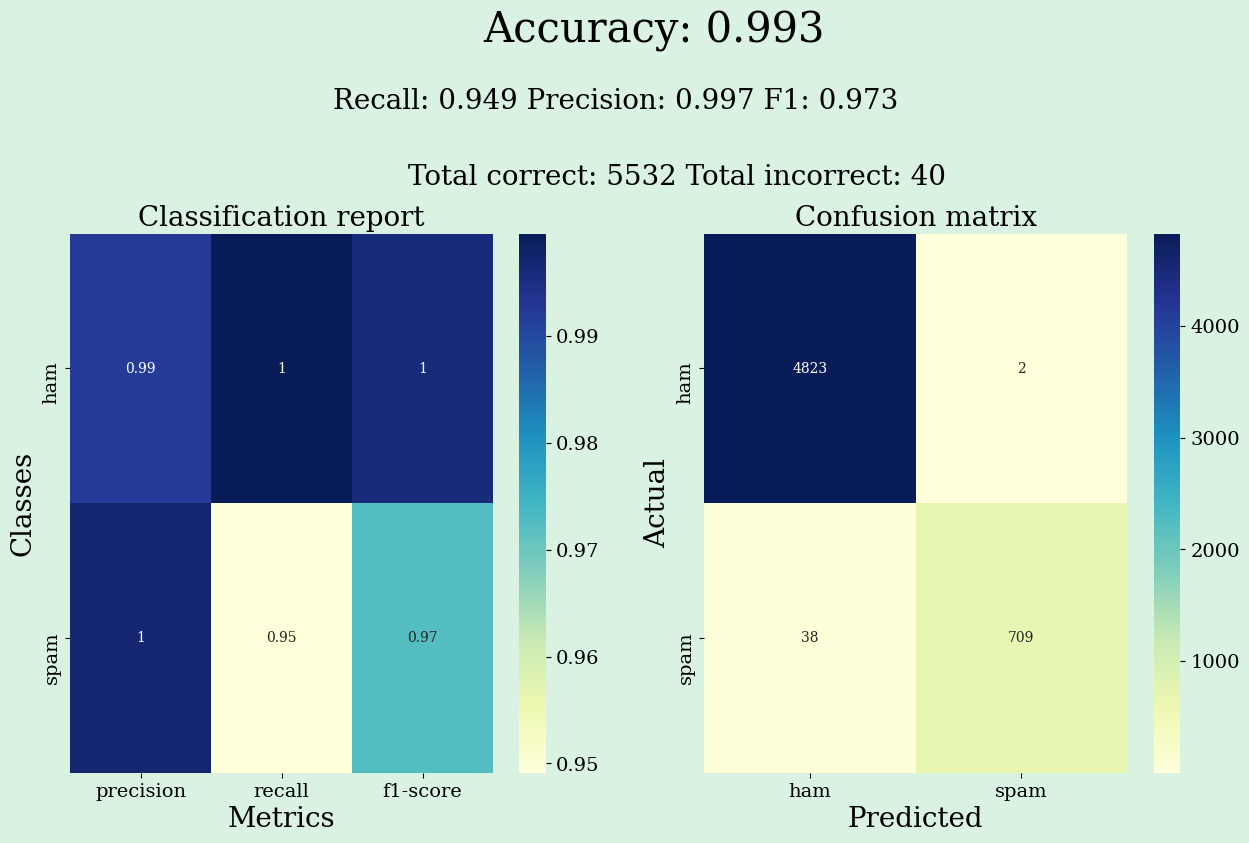

In [52]:
score_df = evaluate_model(LinearSVC(), vectorizer_str='TFIDF',
                          score_df=score_df)

## SVC

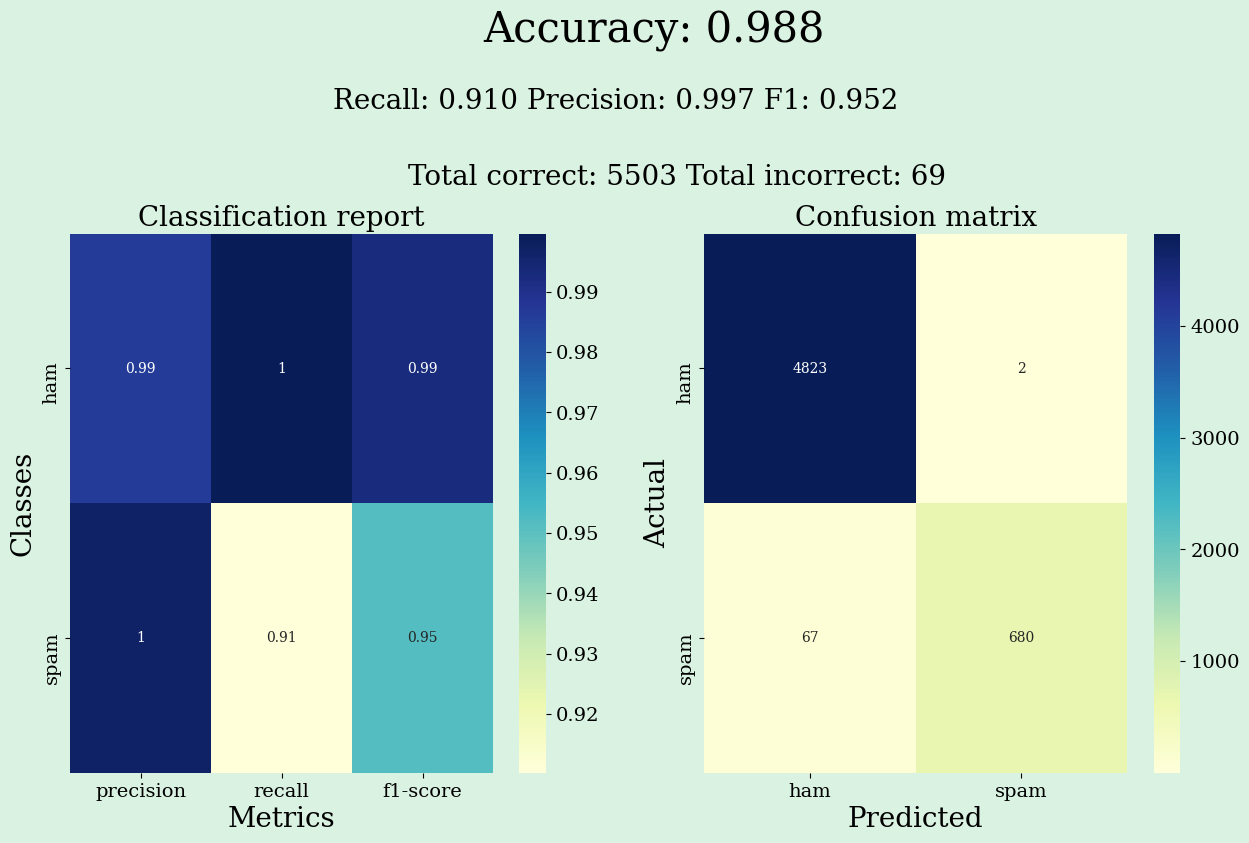

In [53]:
score_df = evaluate_model(SVC(), vectorizer_str='Count',
                          score_df=score_df)

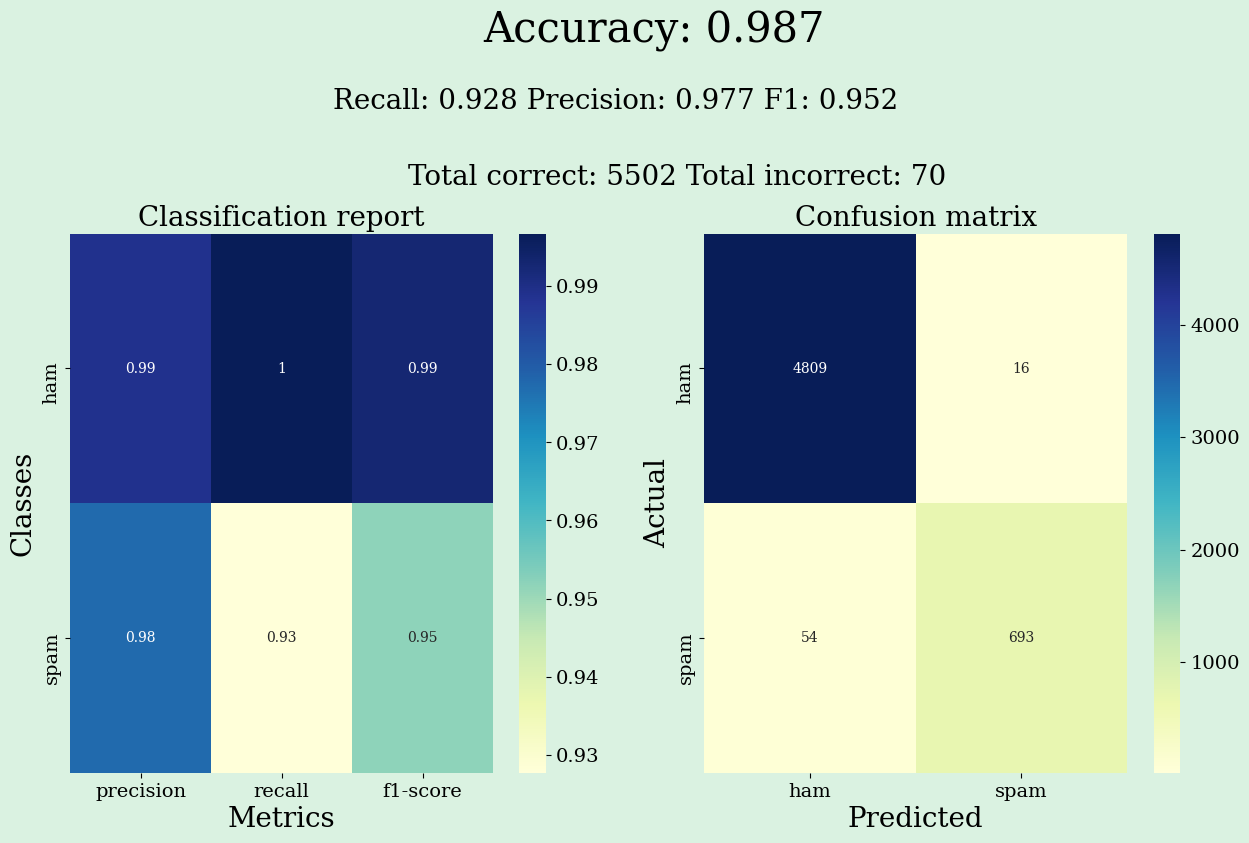

In [54]:
score_df = evaluate_model(SVC(), vectorizer_str='TF',
                          score_df=score_df)

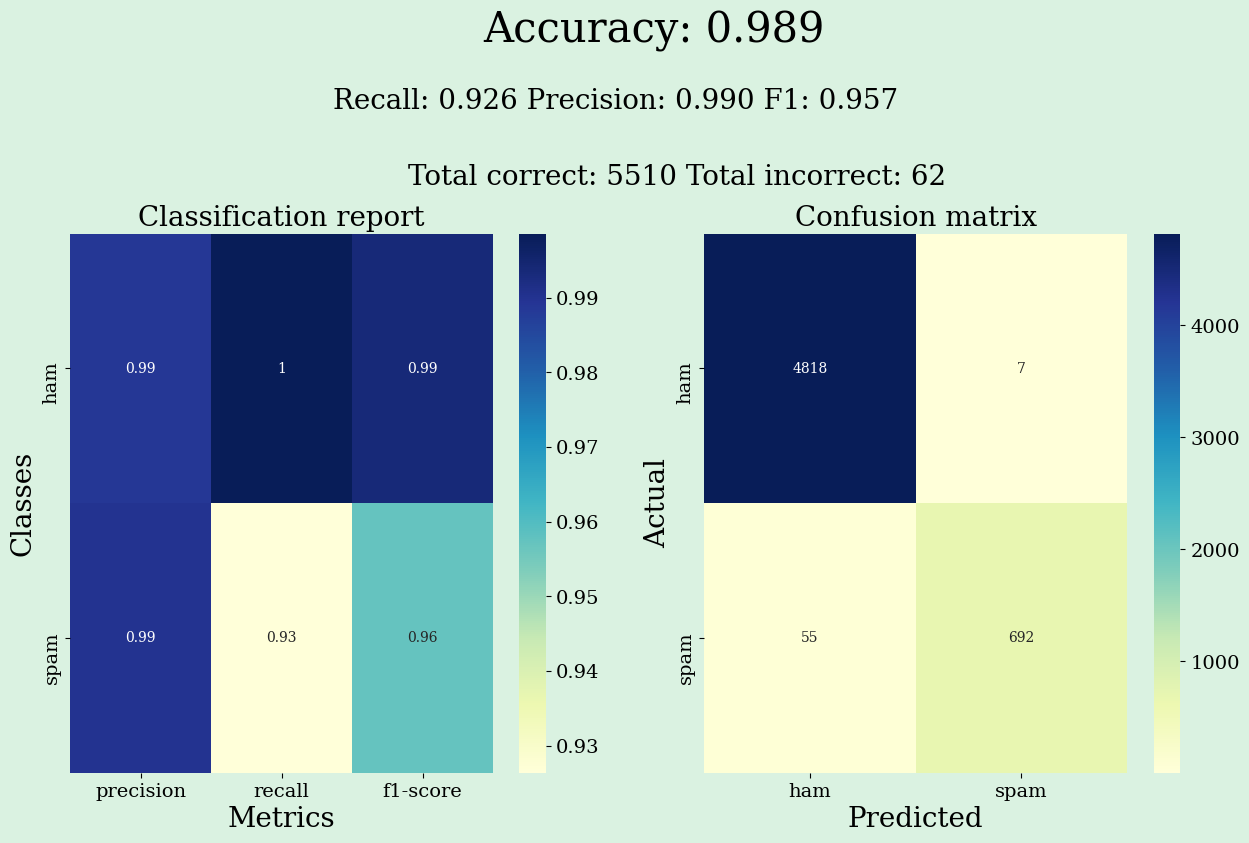

In [55]:
score_df = evaluate_model(SVC(), vectorizer_str='TFIDF',
                          score_df=score_df)

## Random forest

In [56]:
# score_df = evaluate_model(RandomForestClassifier(), vectorizer_str='Count',
#                           score_df=score_df)

In [57]:
# score_df = evaluate_model(RandomForestClassifier(), vectorizer_str='TF',
#                           score_df=score_df)

In [58]:
# score_df = evaluate_model(RandomForestClassifier(), vectorizer_str='TFIDF',
#                           score_df=score_df)

# XGBoost

In [59]:
# score_df = evaluate_model(XGBClassifier(eval_metric='logloss'),
#                           vectorizer_str='Count',
#                           score_df=score_df)

In [60]:
# score_df = evaluate_model(XGBClassifier(eval_metric='logloss'),
#                           vectorizer_str='TF', score_df=score_df)

In [61]:
# score_df = evaluate_model(XGBClassifier(eval_metric='logloss'),
#                           vectorizer_str='TFIDF', score_df=score_df)

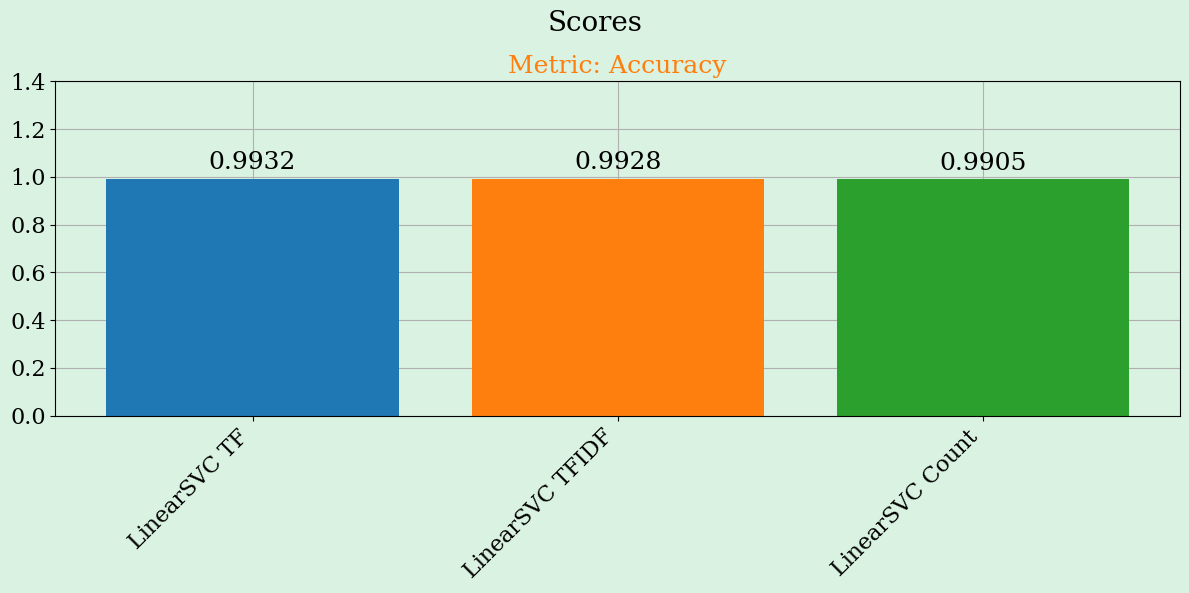

In [62]:
def plot_model_results(score_df, metric='', n_models=3):

    fig, ax = plt.subplots(figsize=(12, 6))
    score_df.sort_values(['Score'], inplace=True, ascending=False)
    rects = ax.bar(x=score_df['ModelName'][:n_models],
                   height=score_df['Score'][:n_models],
                   zorder=2, color=[blue, orange, green])
    autolabel(rects, ax, decimals=4)
    plt.suptitle('Scores', size=20)
    if metric:
        ax.set_title(f'Metric: {metric}', color=orange, size=18)
    ax.set_ylim(0.0, 1.40)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
    plt.tight_layout()
    plt.show();
plot_model_results(score_df, 'Accuracy')

In [63]:
score_df

,ModelName,Score
7,LinearSVC TF,0.993180
8,LinearSVC TFIDF,0.992821
6,LinearSVC Count,0.990488
4,LogisticRegression TF,0.989591
5,LogisticRegression TFIDF,0.989411
3,LogisticRegression Count,0.989232
11,SVC TFIDF,0.988873
2,Text + new features,0.987976
9,SVC Count,0.987617
10,SVC TF,0.987437


<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;
font-style: italic; background:#daf2e1; border-radius: 20px;">Step 4 results:</h2>

1. Chose 2 best models:
    * Linear SVC with TF preprocessing.
    * Logistic regression with TFIDF preprocessing.

<div id="step5">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 5. Analyze model mistakes. </span>

## Error analysis
### According to the new data, we ended up mostly with false negative mistakes. Time to check them.

In [64]:
def incorrect_predictions(X, y, y_hat, y_hat_proba=None):

    incorrect_index = y_hat != y
    X_incorrect = X.copy().loc[incorrect_index]
    X_incorrect['Predicted'] = y_hat[incorrect_index]
    X_incorrect['Actual'] = y.loc[incorrect_index]
    if y_hat_proba is not None:
        X_incorrect['ProbabilityClass1'] = y_hat_proba[:, 0][incorrect_index]
        X_incorrect['ProbabilityClass2'] = y_hat_proba[:, 1][incorrect_index]

    print(f'Total incorrect samples: {len(X_incorrect)}')

    return X_incorrect

## Analyze mistakes

In [65]:
model = LinearSVC()
vectorizer = choose_vectorizer('TF')
pipeline = generate_pipeline(model, vectorizer)
preds, pred_proba = generate_predictions(pipeline)

incorrect_df = incorrect_predictions(X, y, preds, pred_proba)

Total incorrect samples: 38


In [66]:
incorrect_df

,MessageCleared,T&C,PhoneNumber,LengthInSymbols,LengthInWords,Money,Date,Event,Product,Site,UppercaseWords,UppercaseWordsCount,RepeatedPunctuation,Predicted,Actual
68,"Did you hear about the new \Divorce Barbie\""? It comes with all of Ken's stuff!""",False,False,80,15,False,False,False,False,False,False,0,False,ham,spam
226,"Will u meet ur dream partner soon? Is ur career off 2 a flyng start? 2 find out free, text HORO followed by ur star sign, e. g. HORO ARIES",False,False,137,30,False,False,False,False,False,True,3,False,ham,spam
517,Your credits have been topped up for http://www.bubbletext.com Your renewal Pin is tgxxrz,False,False,89,13,False,False,False,False,True,False,0,False,ham,spam
528,You will recieve your tone within the next 24hrs. For Terms and conditions please see Channel U Teletext Pg 750,False,False,111,20,False,False,False,False,False,False,0,False,ham,spam
730,Email AlertFrom: Jeri StewartSize: 2KBSubject: Low-cost prescripiton drvgsTo listen to email call 123,False,False,101,13,False,False,False,False,False,True,1,False,ham,spam
750,"Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?",False,False,102,18,False,True,False,False,False,False,0,False,ham,spam
868,Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r,False,False,134,28,False,False,False,False,False,False,0,False,ham,spam
954,Filthy stories and GIRLS waiting for your,False,False,41,7,False,False,False,False,False,True,1,False,ham,spam
988,"Yun ah.the ubi one say if Ì_ wan call by tomorrow.call 67441233 look for irene.ere only got bus8,22,65,61,66,382. Ubi cres,ubi tech park.6ph for 1st 5wkg days.Ì¬n",False,False,162,26,True,True,False,False,False,False,0,False,spam,ham
1429,For sale - arsenal dartboard. Good condition but no doubles or trebles!,False,False,71,12,False,False,False,False,False,False,0,False,ham,spam


<h2 style="padding: 10px; text-align: left; color:#01872A; font-size: 30px;font-style: italic; background:#daf2e1; border-radius: 20px;">Step 5 results:</h2>

1. Despite the score of a model is very high, there is still some space for
improvement as some messages can be easily identified by the human as spam.
2. At the same time there are some messages that seem to be impossible to
identify as spam even by human, so no models are perfect.

<div id="step6">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 6. Conclusion. </span>

1. The initial data was easy to classify even with simple baseline model.
2. Feature engineering allowed to create a very simple model with 11 features
    to make decent predictions.
3. Using LinearSVC with TF vectorizer resulted in the best results with
    accuracy over 99%.